In [1]:
import numpy as np
import jax
from jax import numpy as jnp
from jax import scipy as jsp
import jaxopt
import matplotlib.pyplot as plt
import galois

import itertools
from functools import partial
import time

In [2]:
def cost_hamiltonian(p, B, F_list):
    # implements the negation of eq. (75) from DQI paper
    m, n = B.shape
    diag_elements = np.zeros(p ** n)

    # since the generalised Z matrix is diagonal, to apply the matrix to the state,
    # don't need to build the whole matrix but just get the diagonal elements of the tensor product
    for idx, x in enumerate(itertools.product(range(p), repeat=n)):
        v = B @ GF(x)
        n_satisfied = sum([v[i] in F_list[i] for i in range(m)])
        diag_elements[idx] = n_satisfied

    return jnp.array(-diag_elements)

In [3]:
def mixing_hamiltonian(n, p):
    # the generalised shift/Pauli X operator is not Hermitian when p > 2
    X = np.zeros((p, p))
    for i in range(p):
        X[(i + 1) % p, i] = 1
        
    dim = p ** n
    I = np.eye(p)
    mixing_h = np.zeros((dim, dim))
    for i in range(n):
        ops = [I] * n
        ops[i] = X
        tensor_prod = ops[0]
        for op in ops[1:]:
            tensor_prod = np.kron(tensor_prod, op)
        mixing_h += tensor_prod + tensor_prod.T # need to make it Hermitian by adding its adjoint
    return jnp.array(mixing_h)

In [4]:
@partial(jax.jit, static_argnames=["n_layers", "n_params_per_layer"])
def simulate_qaoa_qudits(params, n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state):
    state = initial_state
    for layer in range(n_layers):
        cost_unitary = jnp.exp(-1j * params[layer * n_params_per_layer] * cost_h) # vector
        mixing_unitary = mixing_eigvecs @ jnp.diag(jnp.exp(-1j * params[layer * n_params_per_layer + 1] * mixing_eigvals)) @ mixing_eigvecs.conj().T # matrix
        state = mixing_unitary @ (cost_unitary * state)
    return state

In [5]:
@partial(jax.jit, static_argnames=["n_layers", "n_params_per_layer"])
def cost_function(params, n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state):
    state = simulate_qaoa_qudits(params, n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state)
    return jnp.real(jnp.vdot(state, cost_h * state))

In [6]:
def optimize(n_layers, n_params_per_layer, n_trials, cost_h, mixing_eigvals, mixing_eigvecs, initial_state):
    n_params = n_layers * n_params_per_layer
    key = jax.random.key(123)
    lower_bounds = jnp.zeros(n_params)
    upper_bounds = jnp.ones(n_params) * 2 * jnp.pi
    all_params = jax.random.uniform(key, shape = (n_trials, n_params), minval=lower_bounds, maxval=upper_bounds)
    
    sat_fractions = jnp.zeros(n_trials)
    success_list = [0] * n_trials
    status_array = jnp.zeros_like(sat_fractions)
    num_fun_eval_array = jnp.zeros_like(sat_fractions)
    for t in range(n_trials):
        params = all_params[t]
        # TO DO: change the optimiser here to run using GPU
        lbfgsb = jaxopt.ScipyBoundedMinimize(fun=lambda x: cost_function(x, n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state), method="L-BFGS-B")
        opt_params, optstep = lbfgsb.run(params, bounds=(lower_bounds, upper_bounds))
        all_params = all_params.at[t].set(opt_params)
        sat_fractions = sat_fractions.at[t].set(-optstep.fun_val / m)
        success_list[t] = optstep.success
        status_array = status_array.at[t].set(optstep.status)
        num_fun_eval_array = num_fun_eval_array.at[t].set(optstep.num_fun_eval)
           
    return all_params, sat_fractions, success_list, status_array, num_fun_eval_array

In [7]:
def display_results(sat_fractions, final_state, p, B, first=25):
    print("Best expected SAT fraction:", max(sat_fractions))

    m, n = B.shape
    l = (n + 1) // 2
    print("DQI paper semicircle law result:", 1 / 2 + jnp.sqrt(l / m * (1 - l / m)))
    
    prob_dist = abs(final_state) ** 2
    dim = p ** n
    coeffs = np.array(list(itertools.product(range(p), repeat=n)))
    plt.bar(range(dim), prob_dist)
    plt.xticks(range(dim), coeffs)
    plt.show()
    
    sorted_indices = np.flip(jnp.argsort(prob_dist))[:first]
    GF = galois.GF(p)
    for x, prob in zip(coeffs[sorted_indices], prob_dist[sorted_indices]):
        v = B @ GF(x)
        n_satisfied = sum([v[i] in F_list[i] for i in range(m)])
        print("coeffs:", x, "satisfying", n_satisfied, "constraints with probability", prob)

In [8]:
def verification(p, B, F_list):
    m, n = B.shape
    GF = galois.GF(p)
    v_dict = {}
    n_satisfied_dict = {}
    for x in itertools.product(range(p), repeat=n):
        v = B @ GF(x)
        v_dict[x] = v
        n_satisfied = sum([v[i] in F_list[i] for i in range(m)])
        n_satisfied_dict[x] = n_satisfied
    max_satisfied = max(n_satisfied_dict.values())
    max_satisfied_coeffs = [key for key, val in n_satisfied_dict.items() if val == max_satisfied]
    
    return max_satisfied_coeffs, max_satisfied, v_dict, n_satisfied_dict

In [9]:
p = 23 # prime number for the finite field
m = p - 1 # number of constraints, generally for max-LINSAT, m can be any integer, OPI is a special case with m = p - 1
n = 2 # number of coefficients in the polynomial of degree n - 1
GF = galois.GF(p)
primitives = GF.primitive_elements
primitive = primitives[0]
B = GF.Vandermonde(primitive, m, n) # B has a special structure known as Vandermonde matrix for OPI

r = p // 2
rng = np.random.default_rng(151609)
F_list = [rng.permutation(p)[:r] for i in range(m)] # subsets of the finite field that the polynomial should intersect at each point
F_list = jnp.array(F_list)
# F_list = [[primitive ** i, primitive ** i + GF(4)] for i in range(m)] 
# F_list = [[1, 2], [3, 4], [0, 4], [2, 3]]
n_layers = 1
n_params_per_layer = 2
n_trials = 1

cost_h = cost_hamiltonian(p, B, F_list)
mixing_h = mixing_hamiltonian(n, p)
mixing_eigvals, mixing_eigvecs = jnp.linalg.eigh(mixing_h)
initial_state = jnp.ones(p ** n, dtype=jnp.complex64)/jnp.sqrt(p ** n) # |+> state for each qudit (uniform superposition)

Best expected SAT fraction: 0.48953083
DQI paper semicircle law result: 0.7082989


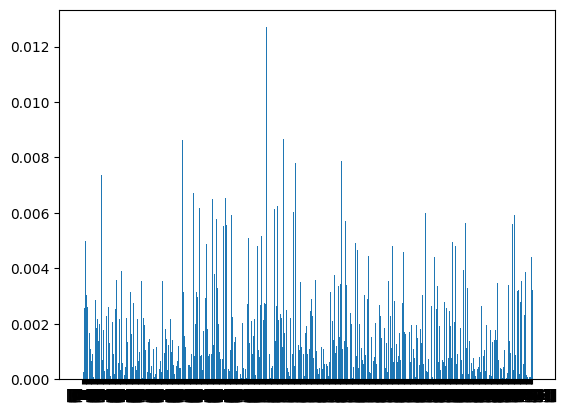

coeffs: [9 9] satisfying 9 constraints with probability 0.012696321
coeffs: [1 4] satisfying 10 constraints with probability 0.010885948
coeffs: [10  6] satisfying 17 constraints with probability 0.008676648
coeffs: [5 3] satisfying 12 constraints with probability 0.008616094
coeffs: [12 17] satisfying 10 constraints with probability 0.008367635
coeffs: [13  5] satisfying 7 constraints with probability 0.007864554
coeffs: [10 20] satisfying 13 constraints with probability 0.007792113
coeffs: [10  1] satisfying 11 constraints with probability 0.0075884764
coeffs: [1 0] satisfying 11 constraints with probability 0.007378393
coeffs: [ 9 18] satisfying 13 constraints with probability 0.006989269
coeffs: [14 11] satisfying 11 constraints with probability 0.0067618624
coeffs: [ 5 16] satisfying 10 constraints with probability 0.0067115403
coeffs: [7 7] satisfying 14 constraints with probability 0.006530219
coeffs: [11  6] satisfying 12 constraints with probability 0.006525613
coeffs: [ 6 15]

In [10]:
opt_params_array, sat_fractions, success_list, status_array, num_fun_eval_array = optimize(n_layers, n_params_per_layer, n_trials, cost_h, mixing_eigvals, mixing_eigvecs, initial_state)
opt_params_array.block_until_ready()
final_state = simulate_qaoa_qudits(opt_params_array[-1], n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state).block_until_ready()
display_results(sat_fractions, final_state, p, B)

In [11]:
max_satisfied_coeffs, max_satisfied, v_dict, n_satisfied_dict = verification(p, B, F_list)
print("coeffs that satify max number of constraints:", max_satisfied_coeffs)
print("max number of satisfied constraints:", max_satisfied)
# print(v_dict)
# print(n_satisfied_dict)

coeffs that satify max number of constraints: [(10, 6), (15, 14), (18, 19)]
max number of satisfied constraints: 17
